In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy as sc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Data: Credit Card Default Analysis
The data were collected from an important bank (a cash and credit card issuer) in Taiwan and the targets were credit card holders of the bank. We would like to explore whether there are differences between customers who defaulted and did not.

In [2]:
credit_card_default_data = pd.read_csv('credit_card_default_analysis.csv')
credit_card_default_data.head()

,ID,LIMIT_BAL,GENDER,EDUCATION,MARITAL,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_JUN,BILL_MAY,BILL_APR,PAY_SEP.1,PAY_AUG.1,PAY_JUL.1,PAY_JUN.1,PAY_MAY.1,PAY_APR.1,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [63]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples
def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [21]:
def permutation_t_stat_2s(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [95]:
def st_pearson_residuals(ct):
    e = sc.stats.chi2_contingency(ct)[3]
    r = e
    n_plus_j = sum(ct, axis=0)
    n_i_plus = sum(ct, axis=1)
    n = sum(n_plus_j)
    for i in range(len(n_i_plus)):
        for j in range(len(n_plus_j)):
            r[i,j] = (ct.values[i,j] - e[i,j]) / np.sqrt(e[i,j] * (1 - n_i_plus[i] / n) * (1 - n_plus_j[j] / n))
    return pd.DataFrame(data=r, index = ct.index, columns = ct.columns)
    

# Assignment

1. Credit limit: test whether there are differences between median credit limits of two groups. 

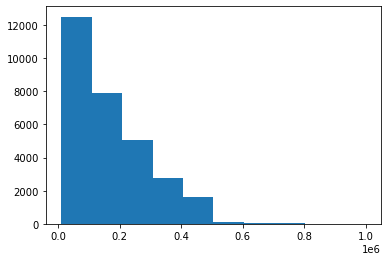

In [3]:
pylab.hist(credit_card_default_data['LIMIT_BAL']);

In [65]:
credit_limit_default = credit_card_default_data[credit_card_default_data['default']==1]['LIMIT_BAL'].values
credit_limit_non_default = credit_card_default_data[credit_card_default_data['default'] == 0]['LIMIT_BAL'].values

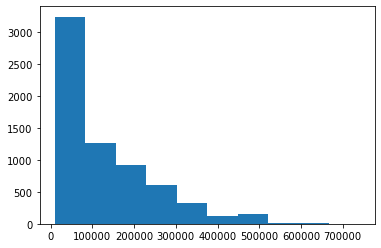

In [66]:
pylab.hist(credit_limit_default);

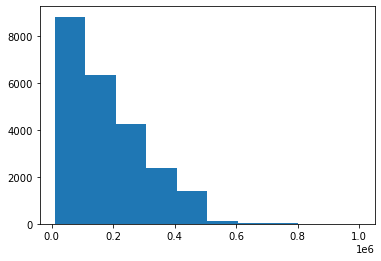

In [67]:
pylab.hist(credit_limit_non_default);

In [29]:
import seaborn as sns

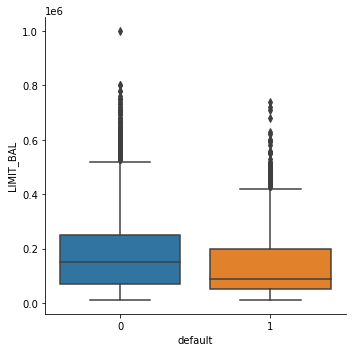

In [30]:
sns.catplot(x="default", y="LIMIT_BAL", kind="box", data = credit_card_default_data);

In [31]:
credit_limit_non_default.median() - credit_limit_default.median()

60000.0

In [68]:
np.random.seed(0)

credit_limit_non_default_median_scores = list(map(np.median, get_bootstrap_samples(credit_limit_non_default, 5000)))
credit_limit_default_median_scores = list(map(np.median, get_bootstrap_samples(credit_limit_default, 5000)))

In [70]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(credit_limit_default_median_scores, credit_limit_non_default_median_scores )))
print("95% confidence interval for the difference between median repair times:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for the difference between median repair times: [60000. 70000.]


In [33]:
res = permutation_test_2s(credit_limit_default, credit_limit_non_default, max_permutations = 10000, alternative = "two-sided", return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = -47990.069655, p = 0.000100


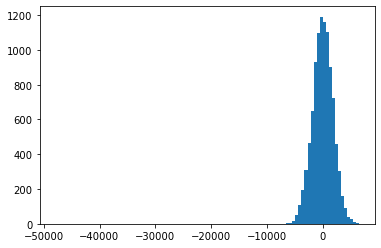

In [41]:
pylab.hist(res['null_distr'], bins = 100);

2. Gender: test whether gender composition of two groups differ. 

In [73]:
default_gender = credit_card_default_data[credit_card_default_data['default']==1]['GENDER']
non_default_gender = credit_card_default_data[credit_card_default_data['default'] == 0]['GENDER']

In [76]:
default_gender_female_count = default_gender[default_gender == 2].shape[0]
default_gender_male_count = default_gender[default_gender == 1].shape[0]

In [78]:
print(default_gender_female_count)
print(default_gender_male_count)

3763
2873


In [80]:
non_default_gender_female_count = non_default_gender[non_default_gender == 2].shape[0]
non_default_gender_male_count = non_default_gender[non_default_gender == 1].shape[0]

In [81]:
print(non_default_gender_female_count)
print(non_default_gender_male_count)

14349
9015


In [82]:
from statsmodels.stats.proportion import confint_proportions_2indep, test_proportions_2indep

In [84]:
print("Wald's interval:", confint_proportions_2indep(14349, 23364,3763, 6636, method = 'wald', compare='diff'))

Wald's interval: (0.03363493274962867, 0.060548077974896725)


In [86]:
print("Wilson's interval based test:", 
      test_proportions_2indep(14349, 23364,3763, 6636, alternative = 'two-sided', 
                              method = 'score', correction=False, return_results=False))

Wilson's interval based test: (6.921259731350102, 4.4764487319331085e-12)


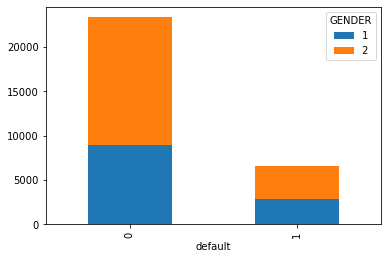

In [38]:
pd.crosstab(credit_card_default_data['default'], credit_card_default_data['GENDER']).plot(kind = "bar", stacked = True)

3. Education: test whether education levels differs between two groups. If it does, then how exactly?

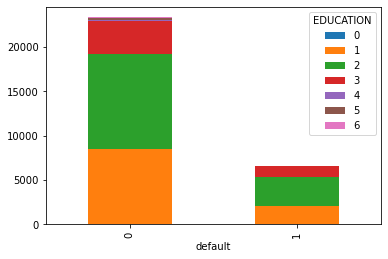

In [51]:
pd.crosstab(credit_card_default_data['default'], credit_card_default_data['EDUCATION']).plot(kind = "bar", stacked = True)

In [89]:
ct_education = pd.crosstab(credit_card_default_data['EDUCATION'], credit_card_default_data['default'])
ct_education

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [91]:
sc.stats.chi2_contingency(ct_education)

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 3.0968000e+00],
        [8.2435980e+03, 2.3414020e+03],
        [1.0926564e+04, 3.1034360e+03],
        [3.8293596e+03, 1.0876404e+03],
        [9.5792400e+01, 2.7207600e+01],
        [2.1806400e+02, 6.1936000e+01],
        [3.9718800e+01, 1.1281200e+01]]))

In [96]:
st_pearson_residuals(ct_education)

default,0,1
EDUCATION,,
0,1.994550,-1.994550
1,8.890227,-8.890227
2,-6.316328,6.316328
3,-5.612397,5.612397
4,4.398948,-4.398948
5,6.355829,-6.355829
6,1.107928,-1.107928


4. Marital status: Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

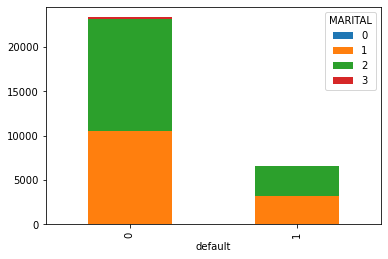

In [97]:
pd.crosstab(credit_card_default_data['default'], credit_card_default_data['MARITAL']).plot(kind = "bar", stacked = True)

In [99]:
ct_marital = pd.crosstab(credit_card_default_data['default'], credit_card_default_data['MARITAL'])
ct_marital

MARITAL,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [100]:
sc.stats.chi2_contingency(ct_marital)

(35.66239583433609,
 8.825862457577375e-08,
 3,
 array([[4.20552000e+01, 1.06376292e+04, 1.24327632e+04, 2.51552400e+02],
        [1.19448000e+01, 3.02137080e+03, 3.53123680e+03, 7.14476000e+01]]))

In [101]:
st_pearson_residuals(ct_marital)

MARITAL,0,1,2,3
default,,,,
0,2.279022,-5.157114,5.303433,-1.691884
1,-2.279022,5.157114,-5.303433,1.691884


5. Age: test whether there are differences between mean ages of clients in two groups. 

In [102]:
default_age = credit_card_default_data[credit_card_default_data['default']==1]['AGE'].values
non_default_age = credit_card_default_data[credit_card_default_data['default'] == 0]['AGE'].values

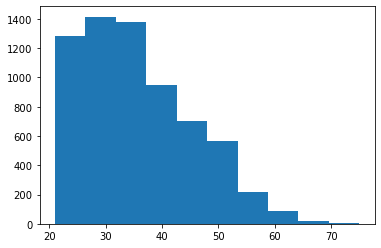

In [104]:
pylab.hist(default_age);

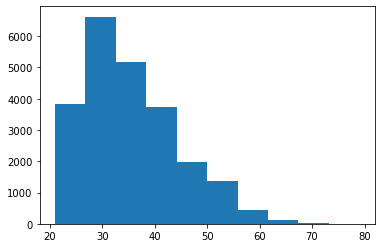

In [106]:
pylab.hist(non_default_age);

In [115]:
default_age

array([24, 26, 30, ..., 37, 41, 46])

In [107]:
default_age.mean() - non_default_age.mean()

0.308472517494188

In [110]:
np.random.seed(0)

non_default_age_mean_scores = list(map(np.mean, get_bootstrap_samples(non_default_age, 5000)))
default_age_mean_scores = list(map(np.mean, get_bootstrap_samples(default_age, 5000)))

In [116]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(non_default_age_mean_scores,default_age_mean_scores)))
print("95% confidence interval for the difference between mean ages:",  
      percentile_interval(delta_median_scores, 0.05))

95% confidence interval for the difference between mean ages: [0.04514264 0.56414004]


In [114]:
res = permutation_test_2s(non_default_age, default_age, max_permutations = 10000, alternative = "two-sided", return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = -0.308473, p = 0.014000
